In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

### Data loading

In [2]:
#Labels:
Gen = np.ravel(pickle.load(open('Gen.pkl','rb')))

#BOW encodings:
X_bw = pickle.load(open('X_bw.pkl','rb'))
X_bw_nogen = pickle.load(open('X_bw_nogen.pkl','rb'))

#Fasttext embeddings:
X_fasttext = pickle.load(open('X_fasttext.pkl','rb'))
X_fasttext_nogen = pickle.load(open('X_fasttext_nogen.pkl','rb'))

In [3]:
#We scale X in order to be able to compare the weights of our model later:
scaler1 = StandardScaler()
scaler1.fit_transform(X_bw)

scaler2 = StandardScaler()
scaler2.fit_transform(X_fasttext)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.28825465,  0.6467136 ,  0.4008463 , ..., -0.61862257,
        -0.76133872, -0.23606496],
       [-1.50290277,  0.0191517 , -0.25294741, ...,  0.79508461,
         1.51577129,  0.5508956 ],
       [ 0.66244361,  0.03831309,  1.13604304, ...,  0.9582038 ,
         0.05723631, -1.03836308],
       ...,
       [ 0.44869188, -0.46052711,  0.64322393, ..., -0.88554879,
         0.62277442, -0.07430039],
       [-1.09060965, -0.09254246,  1.19791272, ..., -1.90354974,
         1.80627611,  1.03872259],
       [ 1.06767497, -0.55007522,  0.00863317, ...,  0.76004191,
        -0.16019708, -0.62814494]])

In [3]:
split_eval = int(0.7*len(X_bw))
split = int(0.8*len(X_bw))
    
#Train sets:
X_bw_train = X_bw[:split_eval]
X_bw_nogen_train = X_bw_nogen[:split_eval]
X_fasttext_train = X_fasttext[:split_eval]
X_fasttext_nogen_train = X_fasttext_nogen[:split_eval]
Gen_train = Gen[:split_eval]

#Eval sets:
X_bw_eval = X_bw[split_eval:split]
X_bw_nogen_eval = X_bw_nogen[split_eval:split]
X_fasttext_eval = X_fasttext[split_eval:split]
X_fasttext_nogen_eval = X_fasttext_nogen[split_eval:split]
Gen_eval = Gen[split_eval:split]

#Test sets:
X_bw_test = X_bw[split:]
X_bw_nogen_test = X_bw_nogen[split:]
X_fasttext_test = X_fasttext[split:]
X_fasttext_nogen_test = X_fasttext_nogen[split:]
Gen_test = Gen[split:] 

# Gender prediction

We are first going to try to predict the gender of the person giving his/her short biography. This will enable us to measure the efficiency of our "Gender informations removal".

## Bag of Words encoding

### With Gender information

We first feed our model with the complete biographies and try to gain insights into which words play a role in the decision.

First, with the logistic regression as described in the paper, it is interesting to look at the weights (taken as feature importance).

In [4]:
def feature_importance_logreg(model, X, n_features=20):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-n_features:]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()

In [6]:
model1 = LogisticRegression(penalty='l2')

model1.fit(X_bw_train, Gen_train)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

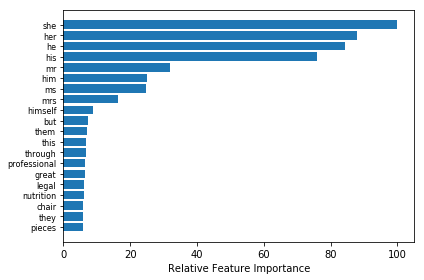

In [7]:
feature_importance_logreg(model1, X_bw)

In [8]:
print('Accuracy of classifier with gender informations on Gender prediction:')
print(accuracy_score(Gen_test, model1.predict(X_bw_test)))

Accuracy of classifier with gender informations on Gender prediction:
0.9972552607502287


### Without Gender information

In [5]:
model2 = LogisticRegression(penalty='l2')

model2.fit(X_bw_nogen_train, Gen_train)

/Users/hugues/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

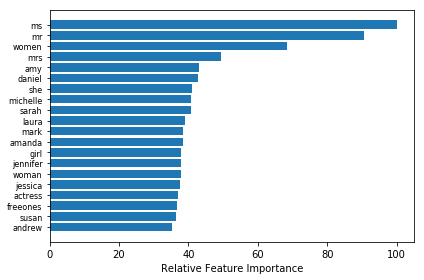

In [6]:
feature_importance_logreg(model2, X_bw_nogen)

In [7]:
print('Accuracy of classifier without gender informations on Gender prediction:')
print(accuracy_score(Gen_test, model2.predict(X_bw_nogen_test)))

Accuracy of classifier without gender informations on Gender prediction:
0.7191216834400732


Our gender information removal is therefore not perfect (score is higher than 0.5).

## Fasttext encoding

### With Gender information

In [10]:
model3 = LogisticRegression(penalty='l2', solver='newton-cg')

model3.fit(X_fasttext_train, Gen_train)

print('Accuracy of classifier with gender informations on Gender prediction:')
print(accuracy_score(Gen_test, model3.predict(X_fasttext_test)))

Accuracy of classifier with gender informations on Gender prediction:
0.8565416285452881


### Without Gender information

In [11]:
model4 = LogisticRegression(penalty='l2', solver='newton-cg')

model4.fit(X_fasttext_nogen_train, Gen_train)

print('Accuracy of classifier without gender informations on Gender prediction:')
print(accuracy_score(Gen_test, model3.predict(X_fasttext_nogen_test)))

Accuracy of classifier without gender informations on Gender prediction:
0.6589204025617567


Fasttext encodings appear to give lower results on gender prediction than Bag of Words. This can probably be explained by the effects of the averaging that tend to lower the importance of decisive wo

#### With boosting models:

In [12]:
boost = xgboost.XGBClassifier(n_estimators=200, booster='gbtree')
eval_set  = [(X_fasttext_nogen_train, Gen_train), (X_fasttext_nogen_eval, Gen_eval)]
boost.fit(X_fasttext_nogen_train, Gen_train, eval_set=eval_set, eval_metric="error", early_stopping_rounds=30, verbose=True)

[0]	validation_0-error:0.395985	validation_1-error:0.402122
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.381659	validation_1-error:0.392609
[2]	validation_0-error:0.379202	validation_1-error:0.392975
[3]	validation_0-error:0.376274	validation_1-error:0.387486
[4]	validation_0-error:0.375438	validation_1-error:0.387486
[5]	validation_0-error:0.373137	validation_1-error:0.381998
[6]	validation_0-error:0.369112	validation_1-error:0.384559
[7]	validation_0-error:0.36702	validation_1-error:0.381632
[8]	validation_0-error:0.364563	validation_1-error:0.385657
[9]	validation_0-error:0.360119	validation_1-error:0.383461
[10]	validation_0-error:0.358812	validation_1-error:0.383096
[11]	validation_0-error:0.356564	validation_1-error:0.381266
[12]	validation_0-error:0.355571	validation_1-error:0.377241
[13]	validation_0-error:0.355152	validation_1-error:0.375

[132]	validation_0-error:0.270978	validation_1-error:0.355287
[133]	validation_0-error:0.270508	validation_1-error:0.354921
[134]	validation_0-error:0.270508	validation_1-error:0.356019
[135]	validation_0-error:0.269305	validation_1-error:0.354921
[136]	validation_0-error:0.269044	validation_1-error:0.355287
[137]	validation_0-error:0.268416	validation_1-error:0.356019
[138]	validation_0-error:0.267737	validation_1-error:0.356751
[139]	validation_0-error:0.267214	validation_1-error:0.356751
[140]	validation_0-error:0.266639	validation_1-error:0.357117
[141]	validation_0-error:0.266639	validation_1-error:0.356019
[142]	validation_0-error:0.265855	validation_1-error:0.356019
[143]	validation_0-error:0.265593	validation_1-error:0.355653
[144]	validation_0-error:0.265384	validation_1-error:0.355653
[145]	validation_0-error:0.265123	validation_1-error:0.35419
[146]	validation_0-error:0.264913	validation_1-error:0.35419
[147]	validation_0-error:0.264757	validation_1-error:0.351262
[148]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [13]:
print('Accuracy of classifier XGBoost without gender informations on Gender prediction:')
print(accuracy_score(Gen_test, boost.predict(X_fasttext_nogen_test)))

Accuracy of classifier XGBoost without gender informations on Gender prediction:
0.6627630375114364


We improve the precision by 1% with XGBoost.